[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb)

In [24]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from core import get_online_quantile
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def smooth_array(arr, window_size):
    # Create a window of ones of length window_size
    window = np.ones(window_size) / window_size
    
    # Use convolve to apply the window to the array
    # 'valid' mode returns output only where the window fits completely
    smoothed = np.convolve(arr, window, mode='same')
    
    return smoothed

/Users/angelopoulos/miniconda3/envs/darts/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/angelopoulos/miniconda3/envs/darts/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/angelopoulos/miniconda3/envs/darts/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/angelopoulos/miniconda3/envs/darts/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

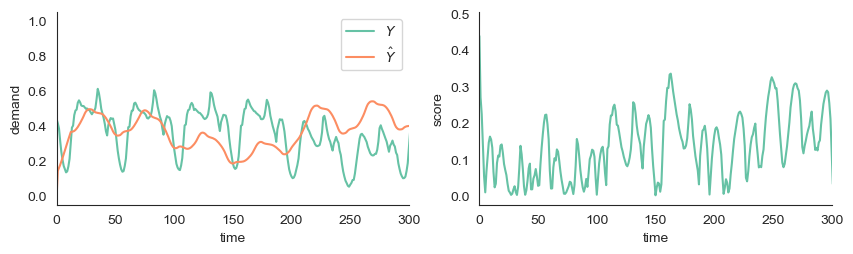

In [27]:
data = pd.read_csv('./data/elec2.csv')
Y = data['nswdemand'].to_numpy()
Yhat = smooth_array(np.roll(Y,-48-48), 24)
Yhat[0] = 0
scores = np.abs(Y - Yhat)

sns.set_style("white")
sns.set_palette('Set2')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,2.5))
sns.lineplot(x=range(Y.shape[0]), y=Y, label=r'$Y$', ax=axs[0])
sns.lineplot(x=range(Y.shape[0]), y=Yhat, label=r'$\hat{Y}$', ax=axs[0])
sns.lineplot(x=range(Y.shape[0]), y=scores, ax=axs[1])
axs[0].set_xlim([0,300])
axs[0].set_xlabel('time')
axs[0].set_ylabel('demand')
axs[1].set_xlim([0,300])
axs[1].set_xlabel('time')
axs[1].set_ylabel('score')
sns.despine(top=True, right=True)
os.makedirs('./results/', exist_ok=True)
plt.savefig('./results/elec2-raw.pdf')

In [21]:
# Problem setup
alpha = 0.1 # 1-alpha is the desired coverage
T = int(scores.shape[0]*0.9) # How long to run for
N_val = scores.shape[0] - T
scores_val = scores[-N_val:]
scores = scores[:-N_val]
etas_fixed = np.ones(T)*0.05
epsilon = 0.1
etas_decaying = np.array([1/(t**(1/2+epsilon)) for t in range(1, T+1)])
q_1 = scores[0]
q_star = np.quantile(scores, 1-alpha)

In [22]:
# Get the quantiles
q_fixed = get_online_quantile(scores, q_1, etas_fixed, alpha)
q_decaying = get_online_quantile(scores, q_1, etas_decaying, alpha)

# Check coverage
observed_coverages_fixed = (scores <= q_fixed).astype(int)
observed_coverages_decaying = (scores <= q_decaying).astype(int)
observed_coverages_oracle = (scores <= q_star).astype(int)

# Smoothed coverage
W = 1000
observed_coverage_fixed = smooth_array(observed_coverages_fixed, W)
observed_coverage_decaying = smooth_array(observed_coverages_decaying, W)
observed_coverage_oracle = smooth_array(observed_coverages_oracle, W)

# Time-conditional coverage
time_coverage_fixed = (scores_val[:,None] <= q_fixed[None,:]).mean(axis=0)
time_coverage_decaying = (scores_val[:,None] <= q_decaying[None,:]).mean(axis=0)
time_coverage_qstar = (scores_val[:,None] <= q_star*np.ones_like(q_decaying)[None,:]).mean(axis=0)

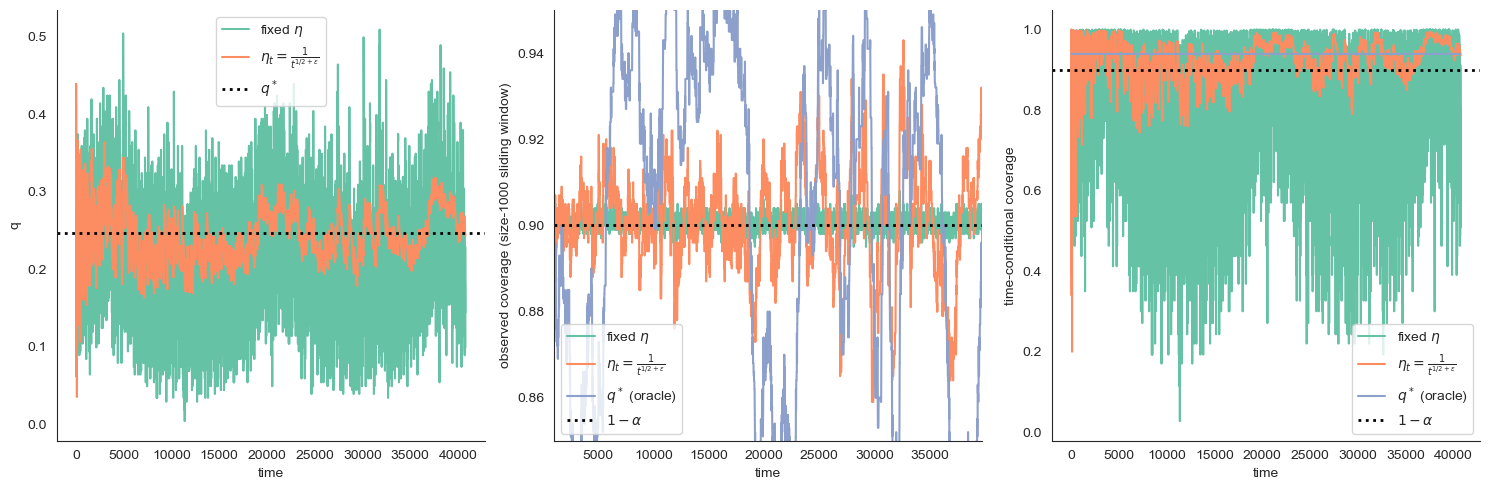

In [23]:
# Plot quantile and coverage
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].plot(range(T), q_fixed, label=r'fixed $\eta$')
axs[0].plot(range(T), q_decaying, label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
axs[0].axhline(y=q_star, linestyle='dotted', color="k", linewidth=2, label=r'$q^*$')
axs[0].set_ylabel('q')
axs[0].set_xlabel('time')
axs[0].legend()
axs[1].plot(range(T), observed_coverage_fixed, label=r'fixed $\eta$')
axs[1].plot(range(T), observed_coverage_decaying, label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
axs[1].plot(range(T), observed_coverage_oracle, label=r'$q^*$ (oracle)')
axs[1].axhline(y=1-alpha, linestyle='dotted', color="k", linewidth=2, label=r'$1-\alpha$')
axs[1].set_xlabel('time')
axs[1].set_ylabel(f"observed coverage (size-{W} sliding window)")
axs[1].set_xlim([W, T-W])
axs[1].set_ylim([0.85, 0.95])
axs[1].legend()
axs[2].plot(range(T), time_coverage_fixed, label=r'fixed $\eta$')
axs[2].plot(range(T), time_coverage_decaying, label=r'$\eta_t = \frac{1}{t^{1/2+\epsilon}}$')
axs[2].plot(range(T), time_coverage_qstar, label=r'$q^*$ (oracle)')
axs[2].axhline(y=1-alpha, linestyle='dotted', color="k", linewidth=2, label=r'$1-\alpha$')
axs[2].set_xlabel('time')
axs[2].set_ylabel(f"time-conditional coverage")
axs[2].legend()
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./results/', exist_ok=True)
plt.savefig('./results/elec2.pdf')